In [2]:
# This notebook is used for the BLAT deepdive and generating Figure 4
import pandas as pd
import boto3
import io
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import numpy as np
from tqdm.auto import tqdm
import ast
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Replace with your file paths
BLAT_results_path = "path/to/Results/semisupervised_results/bydataset_ridge_BLATonly.csv"
unsupervised_results_path = "path/to/Results/unsupervised_results/PG_spearman_correlations_allyears213.csv"

In [5]:
# Data splits BETWEEN datasets of the same protein

blat_keys = [
    "path/to/BLAT_ECOLX_Deng_2012_with_scoresandembeddings_allyears.csv",
    "path/to/BLAT_ECOLX_Jacquier_2013_with_scoresandembeddings_allyears.csv",
    "path/to/BLAT_ECOLX_Firnberg_2014_with_scoresandembeddings_allyears.csv",
    "path/to/BLAT_ECOLX_Stiffler_2015_with_scoresandembeddings_allyears.csv"
]


# Always use the last one as the test set
test_key = blat_keys[-1]
train_keys_seq = blat_keys[:-1]

# Representation types
representation_cols = [f"embedding_120M_{year}" for year in range(2011, 2025)]

# Store results
results = {rep: [] for rep in representation_cols}

for i in range(1, len(train_keys_seq) + 1):
    current_train_keys = train_keys_seq[:i]
    print(current_train_keys)

    for rep in representation_cols:
        print(rep)
        # Load and concatenate training data
        train_dfs = []
        for key in current_train_keys:
            obj = s3.get_object(Bucket=bucket_name, Key=key)
            df = pd.read_csv(io.BytesIO(obj["Body"].read()), converters={rep: parse_list_column})
            df = df[df[rep].notnull()]
            train_dfs.append(df)
        train_df = pd.concat(train_dfs, ignore_index=True)

        # Load test data
        obj = s3.get_object(Bucket=bucket_name, Key=test_key)
        test_df = pd.read_csv(io.BytesIO(obj["Body"].read()), converters={rep: parse_list_column})
        test_df = test_df[test_df[rep].notnull()]

        # Filter for consistent shape
        expected_shape = len(train_df[rep].iloc[0])
        test_df = test_df[test_df[rep].apply(lambda x: len(x) == expected_shape)]

        if len(test_df) == 0:
            print(f" No valid test data for rep {rep} at train size {i}")
            continue

        X_train = np.stack(train_df[rep].values)
        y_train = train_df["DMS_score"].values
        X_test = np.stack(test_df[rep].values)
        y_test = test_df["DMS_score"].values

        model = Ridge(alpha=1.0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        spearman = spearmanr(y_test, y_pred)[0] if np.std(y_test) > 0 and np.std(y_pred) > 0 else np.nan

        results[rep].append({
            "train_size": i,
            "mean_spearman": spearman
        })

# Convert results to DataFrame
all_records = []
for rep, entries in results.items():
    for entry in entries:
        all_records.append({
            "representation": rep,
            "train_size": entry["train_size"],
            "mean_spearman": entry["mean_spearman"]
        })

results_df = pd.DataFrame(all_records)


['DMS_ProteinGym_substitutions/BLAT_ECOLX_Deng_2012_with_scoresandembeddings_allyears.csv']
embedding_120M_2011
embedding_120M_2012
embedding_120M_2013
embedding_120M_2014
embedding_120M_2015
embedding_120M_2016
embedding_120M_2017
embedding_120M_2018
embedding_120M_2019
embedding_120M_2020
embedding_120M_2021
embedding_120M_2022
embedding_120M_2023
embedding_120M_2024
['DMS_ProteinGym_substitutions/BLAT_ECOLX_Deng_2012_with_scoresandembeddings_allyears.csv', 'DMS_ProteinGym_substitutions/BLAT_ECOLX_Jacquier_2013_with_scoresandembeddings_allyears.csv']
embedding_120M_2011
embedding_120M_2012
embedding_120M_2013
embedding_120M_2014
embedding_120M_2015
embedding_120M_2016
embedding_120M_2017
embedding_120M_2018
embedding_120M_2019
embedding_120M_2020
embedding_120M_2021
embedding_120M_2022
embedding_120M_2023
embedding_120M_2024
['DMS_ProteinGym_substitutions/BLAT_ECOLX_Deng_2012_with_scoresandembeddings_allyears.csv', 'DMS_ProteinGym_substitutions/BLAT_ECOLX_Jacquier_2013_with_scoresand

In [6]:
results_df.to_csv(BLAT_results_path)

In [23]:
df = pd.read_csv(BLAT_results_path)
df['year'] = df['representation'].str.extract(r'_(\d{4})').astype(int)
df

,Unnamed: 0,representation,train_size,mean_spearman,year
0,0,embedding_120M_2011,1,0.603689,2011
1,1,embedding_120M_2011,2,0.668998,2011
2,2,embedding_120M_2011,3,0.725733,2011
3,3,embedding_120M_2012,1,0.596517,2012
4,4,embedding_120M_2012,2,0.665989,2012
5,5,embedding_120M_2012,3,0.724643,2012
6,6,embedding_120M_2013,1,0.594269,2013
7,7,embedding_120M_2013,2,0.665533,2013
8,8,embedding_120M_2013,3,0.723056,2013
9,9,embedding_120M_2014,1,0.607318,2014


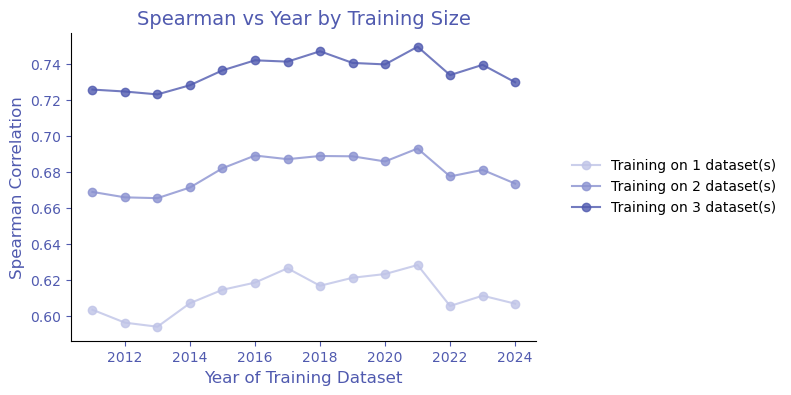

In [4]:
# Define color scheme
base_color = "#505AAF"
lighter_blue = "#8A91D0"
lightest_blue = "#BFC3E7"
black = "#000000"

# Define colors for train_size
color_map = {
    1: lightest_blue,
    2: lighter_blue,
    3: base_color
}

# === Create the plot ===
plt.figure(figsize=(6, 4))

for size in sorted(df['train_size'].unique()):
    subset = df[df['train_size'] == size]
    plt.plot(subset['year'], subset['mean_spearman'], 'o-', label=f"Training on {size} dataset(s)", 
             color=color_map.get(size, black), alpha=0.8)

# === Axis formatting ===
plt.xlabel("Year of Training Dataset", fontsize=12, color=base_color)
plt.ylabel("Spearman Correlation", fontsize=12, color=base_color)
plt.title("Spearman vs Year by Training Size", fontsize=14, color=base_color)

# === Clean up spines and ticks ===
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', colors=base_color)
ax.tick_params(axis='y', colors=base_color)

# === Legend ===
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    frameon=False
)
# === Save and show ===
plt.savefig("figs/spearman_by_year_BLAT.png", dpi=300, bbox_inches="tight")
plt.show()

In [45]:
# add the unsupervised traces to this plot 
df_unsup = pd.read_csv(unsupervised_results_path)
df_unsup = df_unsup[df_unsup["filename"].str.startswith("BLAT")]
df_unsup["dataset"] = (df_unsup["filename"].str.split("_").str[2] + ", " + df_unsup["filename"].str.split("_").str[3])
df_unsup = df_unsup.drop("spearman_random",axis=1)
df_unsup
df_long

,dataset,year,spearman_corr
0,"Deng, 2012",spearman_2011,0.258653
1,"Firnberg, 2014",spearman_2011,0.266756
2,"Jacquier, 2013",spearman_2011,0.309221
3,"Stiffler, 2015",spearman_2011,0.276304
4,"Deng, 2012",spearman_2012,0.258000
5,"Firnberg, 2014",spearman_2012,0.264384
6,"Jacquier, 2013",spearman_2012,0.318446
7,"Stiffler, 2015",spearman_2012,0.274290
8,"Deng, 2012",spearman_2013,0.303919
9,"Firnberg, 2014",spearman_2013,0.326963


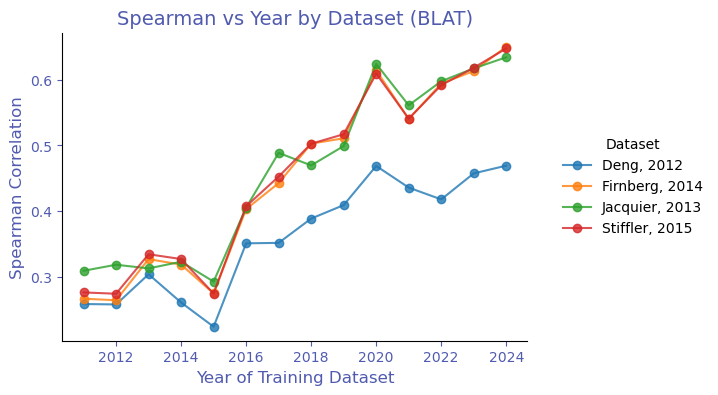

In [50]:
df_long = df_unsup.melt(
    id_vars=["dataset"], 
    value_vars=[col for col in df_unsup.columns if col.startswith("spearman_")],
    var_name="year", 
    value_name="spearman_corr"
)

df_long["year"] = (df_long["year"].str.split("_").str[1]).astype(int)
# === Create the plot ===
plt.figure(figsize=(6, 4))

for dataset in sorted(df_long['dataset'].unique()):
    subset = df_long[df_long['dataset'] == dataset]
    plt.plot(
        subset['year'], 
        subset['spearman_corr'], 
        'o-', 
        label=dataset,
        alpha=0.8
    )

# === Axis formatting ===
plt.xlabel("Year of Training Dataset", fontsize=12, color=base_color)
plt.ylabel("Spearman Correlation", fontsize=12, color=base_color)
plt.title("Spearman vs Year by Dataset (BLAT)", fontsize=14, color=base_color)

# === Clean up spines and ticks ===
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', colors=base_color)
ax.tick_params(axis='y', colors=base_color)

# === Legend ===
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    title="Dataset"
)

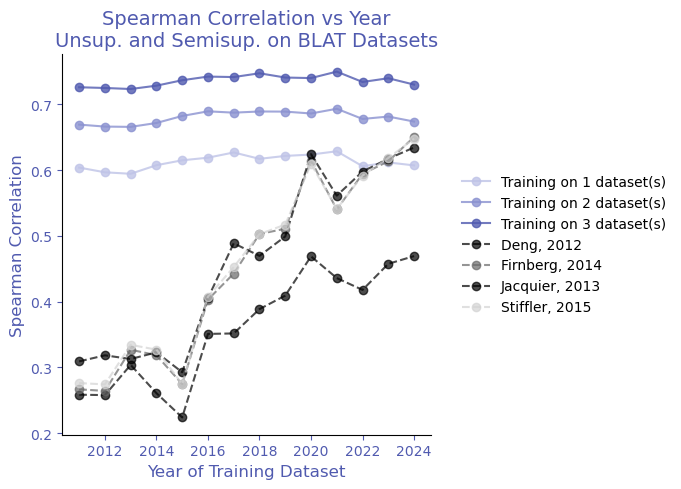

In [51]:
# Plot them together 
df1 = df.copy()
df2 = df_long.copy()
# === Colors ===
base_color = "#505AAF"
lighter_blue = "#8A91D0"
lightest_blue = "#BFC3E7"
black = "#000000"
gray = "#B0B0B0"

color_map = {
    1: lightest_blue,
    2: lighter_blue,
    3: base_color
}

# === Define grey shades for dataset names containing these years ===
grey_shades = {
    "Deng, 2012": "black",
    "Firnberg, 2014": "dimgrey",
    "Jacquier, 2014": "grey",
    "Stiffler, 2015": "lightgrey"
}

# === Start plot ===
plt.figure(figsize=(7, 5))

# === Plot training size lines (df1) ===
for size in sorted(df1['train_size'].unique()):
    subset = df1[df1['train_size'] == size]
    plt.plot(subset['year'], subset['mean_spearman'], 'o-', 
             label=f"Training on {size} dataset(s)", 
             color=color_map.get(size, black), alpha=0.8)

# === Plot BLAT dataset lines (df2) ===
for dataset in sorted(df2['dataset'].unique()):
    subset = df2[df2['dataset'] == dataset]

    # Determine color based on dataset name containing year
    color = "black"  # default if no match
    for year_str, shade in grey_shades.items():
        if year_str in dataset:
            color = shade
            break

    plt.plot(subset['year'], subset['spearman_corr'], 'o--', 
             label=dataset,
             color=color, 
             alpha=0.7)

# === Labels and styling ===
plt.xlabel("Year of Training Dataset", fontsize=12, color=base_color)
plt.ylabel("Spearman Correlation", fontsize=12, color=base_color)
plt.title("Spearman Correlation vs Year\nUnsup. and Semisup. on BLAT Datasets", fontsize=14, color=base_color)

# === Clean up ===
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', colors=base_color)
ax.tick_params(axis='y', colors=base_color)

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
plt.tight_layout()
plt.savefig("figs/combined_spearman_greyBLAT.png", dpi=300, bbox_inches="tight")
plt.show()